In [1]:
import numpy as np
import pandas as pd
import magec_utils as mg
import mimic_utils as mimic
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import seaborn as sns
import shap
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import ReLU
from keras.layers import Input
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import xgboost
import lime

try:
    import cPickle as pickle
except BaseException:
    import pickle
    
# with open("shap_values", "rb") as f:
#     shap_values = pickle.load(f)

# with open("shap_explainer", "rb") as f:
#     explainer = pickle.load(f)


pd.set_option('display.max_columns', None)

%matplotlib inline

Using TensorFlow backend.


In [2]:
def relu_bn(input_tensor):
    relu = ReLU()(input_tensor)
    bn = BatchNormalization()(relu)
    return bn

def get_dropout(input_tensor, p=0.5):
    return Dropout(p)(input_tensor)


def get_model():
    input_shape = xst_train.shape[1:]
    inp = Input(input_shape)
    x = Dense(32, activation=None)(inp)
    x = relu_bn(x)
    x = get_dropout(x, p=0.5)
    x = Dense(64, activation=None)(inp)
    x = relu_bn(x)
    x = get_dropout(x, p=0.5)
    x = Dense(32, activation=None)(inp)
    x = relu_bn(x)
    x = get_dropout(x, p=0.5)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def create_mlp():
    mlp = Sequential()
    mlp.add(Dense(60, input_dim=len(xst_train.columns), activation='relu'))
    mlp.add(Dropout(0.2))
    mlp.add(Dense(30, input_dim=60, activation='relu'))
    mlp.add(Dropout(0.2))
    mlp.add(Dense(1, activation='sigmoid'))
    mlp.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
    return mlp

def impute(df):
    df[labs] = df[labs].fillna(df[labs].mean())
    for vital in vitals:
        df['first_'+vital] = df['first_'+vital].fillna(df['first_'+vital].mean())
        df['last_'+vital] = df['last_'+vital].fillna(df['last_'+vital].mean())    
    df[comobs] = df[comobs].fillna(0)
    return df

def featurize(df, outcome):
    out = dict()
    for lab in labs:
        out[lab] = last_val(df[lab])
    for vital in vitals:
        out['first_'+vital] = first_val(df[vital])
        out['last_'+vital] = last_val(df[vital])
    for comob in comobs:
        out[comob] = last_val(df[comob])
    for other in others:
        out[other] = last_val(df[other])
    out['label'] = int(df[outcome].iloc[-1])
    return pd.Series(out)

def first_val(x):
    vals = list(x[~np.isnan(x)])
    if len(vals):
        return vals[0]
    else:
        return None

def last_val(x):
    vals = list(x[~np.isnan(x)])
    if len(vals):
        return vals[-1]
    else:
        return None

def train_valid_ml(df_ml, test_size=0.2, seed=7):
    np.random.seed(seed)

    x_cols = list(set(df_ml.columns) - {'label'})
    y_cols = ['case', 'label']

    cases = df_ml['case'].unique()

    np.random.shuffle(cases)  # inplace shuffle

    valid_cases = cases[:int(len(cases) * test_size)]
    train_cases = cases[int(len(cases) * test_size):]

    train_cases = np.isin(df_ml['case'], train_cases)
    valid_cases = np.isin(df_ml['case'], valid_cases)

    xy_train = df_ml.loc[train_cases, :]
    x_train = xy_train[x_cols].copy()
    Y_train = xy_train[y_cols].copy()

    Y_train['label'] = Y_train['label'].astype(int)
    Y_train['timepoint'] = 0
    Y_train = Y_train.set_index(['case', 'timepoint'])
    
    xy_valid = df_ml.loc[valid_cases, :]
    x_valid = xy_valid[x_cols].copy()
    Y_valid = xy_valid[y_cols].copy()
    
    Y_valid['label'] = Y_valid['label'].astype(int)
    Y_valid['timepoint'] = 0
    Y_valid = Y_valid.set_index(['case', 'timepoint'])
    
    x_train = impute(x_train)
    x_train['timepoint'] = 0
    x_valid = impute(x_valid)
    x_valid['timepoint'] = 0
    
    x_train = x_train.set_index(['case', 'timepoint'])
    
    x_valid = x_valid.set_index(['case', 'timepoint'])
    
    feats = x_train.columns
    
    bool_cols = [col for col in feats if df_ml[col].dropna().value_counts().index.isin([0,1]).all()]
    non_bool_cols = [col for col in feats if col not in bool_cols]
     
    stsc = StandardScaler()
    xst_train = x_train.copy()
    xst_train[non_bool_cols] = stsc.fit_transform(x_train[non_bool_cols])
    xst_train = pd.DataFrame(xst_train, index=x_train.index, columns=x_train.columns)

    xst_valid = x_valid.copy()
    xst_valid[non_bool_cols] = stsc.transform(x_valid[non_bool_cols])
    xst_valid = pd.DataFrame(xst_valid, index=x_valid.index, columns=x_valid.columns)

    return x_train, x_valid, stsc, xst_train, xst_valid, Y_train, Y_valid

In [3]:
# MIMIC-III
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']

labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit

comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']

others = ['age', 'gender']

features = vitals+labs

df_cohort = mimic.get_mimic_data()

In [4]:
df_ml = df_cohort.rename(columns={'subject_id': 'case'})
df_ml = df_ml.set_index(['case', 'timepoint'])
df_ml = df_ml.sort_index(level=[0, 1], ascending=[1, 0])

In [5]:
df_ml = df_ml.reset_index(1).groupby(level=0, group_keys=False).apply(lambda x: featurize(x, 'ventilated'))

In [6]:
x_train, x_valid, stsc, xst_train, xst_valid, Y_train, Y_valid = train_valid_ml(df_ml.reset_index())

In [7]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_train['label']),
                                                  Y_train['label'])
print(class_weights)

[0.61911131 2.59887711]


In [8]:
# mlp2 = KerasClassifier(build_fn=get_model, epochs=100, batch_size=64, verbose=0)
# mlp2.fit(xst_train, 
#          Y_train['label'], 
#          epochs=100, 
#          batch_size=64, 
#          verbose=0, 
#          class_weight={0:class_weights[0], 1:class_weights[1]}, )
# print('Built new MLP classifier!')
# mg.evaluate(mlp2, xst_valid, Y_valid['label'], verbose=True);

In [9]:
mlp = KerasClassifier(build_fn=create_mlp, epochs=100, batch_size=64, verbose=0)
mlp.fit(xst_train, Y_train['label'], 
        epochs=100, 
        batch_size=64, 
        verbose=0, 
        class_weight={0:class_weights[0], 1:class_weights[1]}, )
print('Built MLP classifier!')

sv = svm.SVC(probability=True, class_weight="balanced")
sv.fit(xst_train, Y_train['label'])
print('Built SVM classifier!')

lr = LogisticRegression(C=1., class_weight='balanced', solver='lbfgs')
lr.fit(xst_train, Y_train['label'])
print('Built LR classifier!')

Built MLP classifier!
Built SVM classifier!
Built LR classifier!


In [10]:
mg.evaluate(mlp, xst_valid, Y_valid['label'], verbose=True);
mg.evaluate(sv, xst_valid, Y_valid['label'], verbose=True);
mg.evaluate(lr, xst_valid, Y_valid['label'], verbose=True);

Accuracy: 0.821411
Precision: 0.545825
Recall: 0.642686
F1 score: 0.590308
ROC AUC: 0.834504
[[1443  223]
 [ 149  268]]
Accuracy: 0.783485
Precision: 0.472131
Recall: 0.690647
F1 score: 0.560857
ROC AUC: 0.813892
[[1344  322]
 [ 129  288]]
Accuracy: 0.672588
Precision: 0.339782
Recall: 0.673861
F1 score: 0.451768
ROC AUC: 0.721519
[[1120  546]
 [ 136  281]]


In [ ]:
# mg.evaluate(mlp, xst_valid, Y_valid['label'], verbose=True);
# mg.evaluate(sv, xst_valid, Y_valid['label'], verbose=True);
# mg.evaluate(lr, xst_valid, Y_valid['label'], verbose=True);

In [11]:
xg = xgboost.XGBClassifier(scale_pos_weight=4)
xg.fit(xst_train, Y_train['label'])
mg.evaluate(xg, xst_valid, Y_valid['label'], verbose=True);

Accuracy: 0.818051
Precision: 0.536260
Recall: 0.673861
F1 score: 0.597237
ROC AUC: 0.835186
[[1423  243]
 [ 136  281]]


In [12]:
explainer = shap.TreeExplainer(xg)

In [13]:
shap_values = explainer.shap_values(xst_valid)

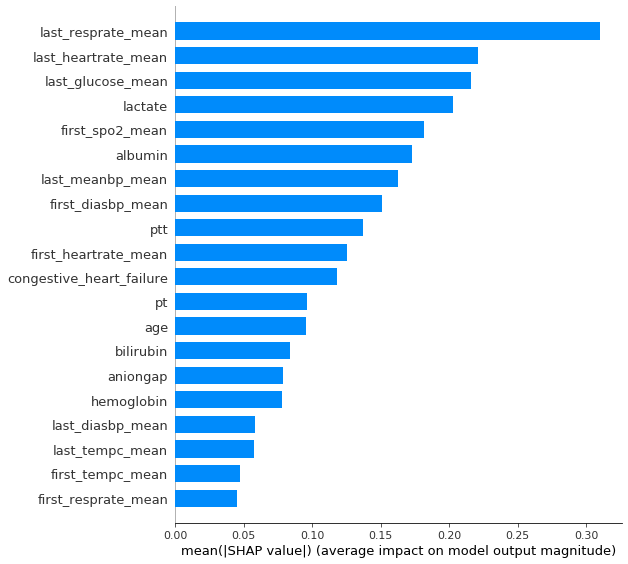

In [14]:
shap.summary_plot(shap_values, xst_valid, plot_type="bar")

In [15]:
shaps = {x[1]:x[0] for x in zip(list(np.abs(shap_values).mean(0)), list(xst_valid.columns))}
shaps = pd.DataFrame.from_dict(shaps, orient='index', columns=['shap']).\
    reset_index().rename(columns={'index': 'feature'})

In [16]:
shaps.head()

,feature,shap
0,last_tempc_mean,0.057257
1,chloride,0.003261
2,first_glucose_mean,0.013679
3,inr,0.037258
4,first_diasbp_mean,0.150705


In [17]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    xst_train.values,
    training_labels=Y_train['label'].values,
    feature_names=xst_train.columns.tolist(),
    feature_selection="lasso_path",
    class_names=[0, 1],
    discretize_continuous=True,
    discretizer="entropy",
)

In [21]:
lime_explainerxplainer = lime.lime_tabular.LimeTabularExplainer(
    xst_train, 
    feature_names=list(xst_train.columns), 
    class_names=["0", "1"], 
    discretize_continuous=True)

In [23]:
exp = lime_explainerxplainer.explain_instance(xst_valid.iloc[0], xg.predict_proba)

In [26]:
print(3)

In [19]:
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(lime_explainer, 
                                        xst_train.values, 
                                        xg.predict_proba, 
                                        sample_size=500, 
                                        num_features=41, 
                                        num_exps_desired=5)
#Plot the 5 explanations
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];
# Make it into a dataframe
W_pick = pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)
 
W_pick['prediction'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]
 
#Making a dataframe of all the explanations of sampled points
W = pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]
 
#Plotting the aggregate importances
np.abs(W.drop("prediction", axis=1)).mean(axis=0).sort_values(ascending=False).head(
    25
).sort_values(ascending=True).iplot(kind="barh")
 
#Aggregate importances split by classes
grped_coeff = W.groupby("prediction").mean()
 
grped_coeff = grped_coeff.T
grped_coeff["abs"] = np.abs(grped_coeff.iloc[:, 0])
grped_coeff.sort_values("abs", inplace=True, ascending=False)
grped_coeff.head(25).sort_values("abs", ascending=True).drop("abs", axis=1).iplot(
    kind="barh", bargap=0.5
) 

ValueError: feature_names mismatch: ['last_tempc_mean', 'chloride', 'first_glucose_mean', 'inr', 'first_diasbp_mean', 'platelet', 'first_meanbp_mean', 'last_resprate_mean', 'magnesium', 'last_sysbp_mean', 'sodium', 'last_meanbp_mean', 'first_spo2_mean', 'first_tempc_mean', 'glucose', 'aniongap', 'first_sysbp_mean', 'last_diasbp_mean', 'pulmonary_circulation', 'gender', 'bilirubin', 'lactate', 'creatinine', 'pt', 'congestive_heart_failure', 'age', 'last_heartrate_mean', 'ptt', 'first_resprate_mean', 'last_glucose_mean', 'chronic_pulmonary', 'first_heartrate_mean', 'bun', 'hemoglobin', 'wbc', 'bicarbonate', 'last_spo2_mean', 'phosphate', 'potassium', 'albumin'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39']
expected last_tempc_mean, chloride, first_glucose_mean, inr, first_diasbp_mean, platelet, first_meanbp_mean, last_resprate_mean, magnesium, last_sysbp_mean, sodium, last_meanbp_mean, first_spo2_mean, first_tempc_mean, glucose, aniongap, first_sysbp_mean, last_diasbp_mean, pulmonary_circulation, gender, bilirubin, lactate, creatinine, pt, congestive_heart_failure, age, last_heartrate_mean, ptt, first_resprate_mean, last_glucose_mean, chronic_pulmonary, first_heartrate_mean, bun, hemoglobin, wbc, bicarbonate, last_spo2_mean, phosphate, potassium, albumin in input data
training data did not have the following fields: f30, f16, f17, f2, f27, f31, f12, f38, f1, f37, f18, f20, f10, f21, f24, f6, f22, f4, f5, f35, f32, f23, f34, f13, f36, f19, f9, f28, f26, f0, f7, f39, f33, f8, f3, f29, f15, f14, f25, f11

In [ ]:
def most_abnormal(x, features):
    res = None
    feat = None
    for f in features:
        if res is None or abs(x[f]) > res:
            res = abs(x[f])
            feat = f
    return feat

def get_magecs(lr, sv, mlp, xst_valid, Ydata, baseline=None):
    magecs_lr = mg.case_magecs(lr, xst_valid, model_name='lr', baseline=baseline)
    magecs_lr = mg.normalize_magecs(magecs_lr, features=None, model_name='lr')

    magecs_svm = mg.case_magecs(sv, xst_valid, model_name='svm', baseline=baseline)
    magecs_svm = mg.normalize_magecs(magecs_svm, features=None, model_name='svm')

    magecs_mlp = mg.case_magecs(mlp, xst_valid, model_name='mlp', baseline=baseline)
    magecs_mlp = mg.normalize_magecs(magecs_mlp, features=None, model_name='mlp')
    
    feats = list(xst_valid.columns)
    
    joined = mg.magec_models(magecs_mlp, magecs_svm, magecs_lr, 
                             Xdata=xst_valid, Ydata=Ydata['label'], features=feats)
    
    prob_cols = [c for c in joined.columns if c.startswith('perturb') and '_'.join(c.split('_')[1:-2]) in feats]
    joined['orig_prob_ensemble'] = joined[['orig_prob_mlp', 'orig_prob_lr', 'orig_prob_svm']].apply(np.mean, 1)
    joined[['best_feat', 'new_risk', 'rank_feat', 'rank_val', 'top_rank_prob']] = joined.apply(
        lambda x: mimic.best_feature(x, prob_cols), axis=1)
    joined['most_abnormal'] = joined.apply(lambda x: most_abnormal(x, feats), axis=1)
    
    ranks = mg.magec_rank(joined, rank=len(feats), features=feats, models=('mlp', 'lr', 'svm'))
    
    rbos = mg.magec_rbos(ranks, models=('mlp', 'lr', 'svm'))
    rbos['rbo'] = rbos[['mlp_lr', 'svm_lr', 'svm_mlp']].apply(np.mean, 1)
    
    consensus = mg.magec_consensus(ranks, models=('mlp', 'lr', 'svm'))
    
    consensus = consensus.merge(Ydata.reset_index()[['case','label']], left_on='case', right_on='case')
    
    consensus = consensus.merge(rbos[['rbo', 'case']], left_on='case', right_on='case')
    
    return joined, ranks, consensus

In [ ]:
joined_zero, ranks_zero, consensus_zero = get_magecs(lr, sv, mlp, xst_valid, Y_valid, baseline=None)

In [ ]:
def plot_feat_importance(consensus, shaps, title='', feats=None, save=''):
    if feats is not None:
        df = consensus[np.isin(consensus['winner'], feats)]
    else:
        df = consensus
    order = list(df[df['label']==1][['winner']].winner.value_counts().index.values)
    
    a4_dims = (28, 12)
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=a4_dims)
    
    sns.countplot(y="winner", 
                  hue="label", 
                  palette="pastel", 
                  edgecolor=".6",
                  data=df, 
                  order=order,
                  ax=ax[0]);

    sns.barplot(x='shap', 
                y='feature' ,
                data=shaps, 
                order=order,
                palette="pastel", 
                edgecolor=".6",
                ax=ax[1]);
    
    ax[1].set_ylabel('')
    ax[0].set_title('Top MAgEC Feature' + title)
    ax[0].set_ylabel('Top Magec')
    ax[1].set_xlabel('mean(|SHAP value|)')
    ax[1].set_title('Feature importance using SHAP')
    
    ax[0].grid('on')
    ax[1].grid('on')
    
    for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
             ax[0].get_xticklabels() + ax[0].get_yticklabels()):
        item.set_fontsize(21)
        
    for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
             ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        item.set_fontsize(21)
    
    plt.tight_layout()

    if save:
        fig.savefig(save, bbox_inches='tight')

In [ ]:
plot_feat_importance(consensus_zero, shaps, save='magec_shap.png')

In [ ]:
consensus_zero.head()

In [ ]:
ranks_zero.head()

In [ ]:
joined_p5, ranks_p5, consensus_p5 = get_magecs(lr, sv, mlp, xst_valid, Y_valid, baseline=0.5)

In [ ]:
joined_p3, ranks_p3, consensus_p3 = get_magecs(lr, sv, mlp, xst_valid, Y_valid, baseline=0.3)

In [ ]:
joined_p1, ranks_p1, consensus_p1 = get_magecs(lr, sv, mlp, xst_valid, Y_valid, baseline=0.1)

In [ ]:
def plot_consensus(consensus, score=False, title='', feats=None, save=''):
    if feats is not None:
        df = consensus[np.isin(consensus['winner'], feats)]
    else:
        df = consensus
    order = list(df[df['label']==1][['winner']].winner.value_counts().index.values)
    
    a4_dims = (28, 12)
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=a4_dims)
    
    if score:
        sns.barplot(x='score', 
                    y='winner',
                    hue="label",
                    data=df, 
                    order=order,
                    palette="pastel", 
                    edgecolor=".6",
                    ax=ax[0]);
    else:
        sns.countplot(y="winner", 
                      hue="label", 
                      palette="pastel", 
                      edgecolor=".6",
                      data=df, 
                      order=order,
                      ax=ax[0]);

    sns.barplot(x='rbo', 
                y='winner' ,
                data=df, 
                order=order,
                palette="pastel", 
                edgecolor=".6",
                ax=ax[1]);
    
    ax[1].set_ylabel('')
    ax[0].set_title('Top MAgEC Feature' + title)
    ax[0].set_ylabel('Top Magec')
    ax[1].set_xlabel('Average RBO')
    ax[1].set_title('Top MAgEC Feature Average RBO')
    
    ax[0].grid('on')
    ax[1].grid('on')
    
    for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
             ax[0].get_xticklabels() + ax[0].get_yticklabels()):
        item.set_fontsize(21)
        
    for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
             ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        item.set_fontsize(21)
    
    plt.tight_layout()

    if save:
        fig.savefig(save, bbox_inches='tight')

In [ ]:
# pd.DataFrame(consensus_zero.groupby(['winner'])['score'].mean()).reset_index()

In [ ]:
# plot_consensus(consensus_zero, title=' ("full" perturbation)')

In [ ]:
# plot_consensus(consensus_zero, title=' ("full" perturbation)', save='magec_top_rbo_full.png')

In [ ]:
# plot_consensus(consensus_p5, title=' ("0.5" perturbation)', save='magec_top_rbo_p5.png')

In [ ]:
# plot_consensus(consensus_p1, title=' ("0.1" perturbation)', save='magec_top_rbo_p1.png')

In [ ]:
bool_cols = [col for col in list(xst_valid.columns) 
             if df_ml[col].dropna().value_counts().index.isin([0,1]).all()]
non_bool_cols = [col for col in list(xst_valid.columns) 
                 if col not in bool_cols]

In [ ]:
# plot_consensus(consensus_p1, non_bool_cols)

In [ ]:
# plot_consensus(consensus_zero, non_bool_cols)

In [ ]:
# consensus_zero.groupby(['winner'])['consensus'].agg(count=np.sum, mean=np.mean, std=np.std).\
#     sort_values('count', ascending=False).head(10)

In [ ]:
# consensus_p5.groupby(['winner'])['consensus'].agg(count=np.sum, mean=np.mean, std=np.std).\
#     sort_values('count', ascending=False).head(10)

In [ ]:
# consensus_p1.groupby(['winner'])['consensus'].agg(count=np.sum, mean=np.mean, std=np.std).\
#     sort_values('count', ascending=False).head(10)

In [ ]:
c1 = consensus_zero[['case','winner','label','score']].copy()
c1['perturb'] = 'full'

c2 = consensus_p5[['case','winner','label','score']].copy()
c2['perturb'] = '0.5'

c3 = consensus_p3[['case','winner','label','score']].copy()
c3['perturb'] = '0.3'

c4 = consensus_p1[['case','winner','label','score']].copy()
c4['perturb'] = '0.1'

consens = pd.concat([c1, c2, c3, c4], axis=0)

In [ ]:
len(consens) == 4 * len(consensus_zero)

In [ ]:
consens.head()

In [ ]:
consens = consens[np.isin(consens['winner'], non_bool_cols)]

In [ ]:
def plot_sensitivity(consens, title='', topK=None, save=''):

    
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(28, 12), sharey=True)
        
    df = consens
    order = list(df[(df['label']==1)&(df['perturb']=='full')][['winner']].winner.value_counts().index.values) 
    if topK is not None:
        order =  order[:topK]
        df = df[np.isin(df['winner'], order)]
        
    sns.countplot(y="winner", 
                  hue="perturb", 
                  palette="pastel", 
                  edgecolor=".6",
                  data=df[df['label']==1], 
                  order=order,
                  ax=ax[0]);
    
    sns.countplot(y="winner", 
                  hue="perturb", 
                  palette="pastel", 
                  edgecolor=".6",
                  data=df[df['label']==0], 
                  order=order,
                  ax=ax[1]);
        
    
    ax[0].set_title('Label=1' + title)
    ax[0].set_ylabel('Top Magec')
    ax[0].grid('on')
    
    ax[1].set_ylabel('')
    ax[1].set_title('Label=0' + title)
    ax[1].grid('on')
    
    for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
             ax[0].get_xticklabels() + ax[0].get_yticklabels()):
        item.set_fontsize(21)
        
    for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
             ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        item.set_fontsize(21)
    
    plt.tight_layout()

    if save:
        fig.savefig(save, bbox_inches='tight')

In [ ]:
plot_sensitivity(consens, topK=15, title=' (top 15 features)', save='magec_sensitivity.png')

In [ ]:
def plot_rbo(df, save=''):
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 14))
    order = list(df.winner.value_counts().index.values)
    sns.barplot(x='rbo', 
                y='winner' ,
                data=df, 
                order=order,
                palette="pastel", 
                edgecolor=".6",
                ci=None,
                ax=ax);
    ax.grid('on')
    ax.set_title('MAgEC Average RBO')
    ax.set_ylabel('Top MAgEC')
    ax.set_xlabel('Average RBO from pairwise model RBOs')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(21)
    if save:
        fig.savefig(save, bbox_inches='tight')

In [ ]:
plot_rbo(consensus_zero, save='magec_rbos.png')

In [ ]:
def rank_scores(ranks):
    scores = {}
    for (idx, row) in ranks.iterrows():
        for i in range(1, 41):
            for m in ('lr', 'svm', 'mlp'):
                tmp = row[m + '_feat_' + str(i)]
                if tmp != 'not_found':
                    score = row[m + '_magec_' + str(i)]
                    if tmp not in scores:
                        scores[tmp] = abs(score)  # 1/i
                    else:
                        scores[tmp] += abs(score) # 1/i
    scores = pd.DataFrame.from_dict(scores, orient='index')
    scores = scores.reset_index()
    scores.columns = ['feature', 'score']
    return scores 

In [ ]:
ranks_zero_scores = rank_scores(ranks_zero)
ranks_zero_scores['perturb'] = 'full'
ranks_p5_scores = rank_scores(ranks_p5)
ranks_p5_scores['perturb'] = '0.5'
ranks_p1_scores = rank_scores(ranks_p1)
ranks_p1_scores['perturb'] = '0.1'
ranks_scores = pd.concat([ranks_zero_scores, ranks_p5_scores, ranks_p1_scores])

In [ ]:
ranks_scores.head()

In [ ]:
def bar_plot(df, score='score', feats=None, save=False,  topK=None):
    if feats is not None:
        df = df[np.isin(df['feature'], feats)]
    else:
        df = df
    order = list(df.sort_values(score, ascending=False)['feature'].unique())
    if topK is not None:
        order =  order[:topK]
        df = df[np.isin(df['feature'], order)]
    #a4_dims = (11.7, 8.27)
    a4_dims = (12, 20)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.barplot(x=score, y='feature', hue='perturb', 
                data=df, 
                order=order,
                palette="pastel", 
                edgecolor=".6",
                ax=ax)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(21)
        
    if save:
        fig.savefig("magec_ranks.png", bbox_inches='tight')

In [ ]:
bar_plot(ranks_scores, feats=non_bool_cols)

In [ ]:
bar_plot(ranks_scores, feats=non_bool_cols, save=True)

In [ ]:
bar_plot(ranks_scores, topK=10)

In [ ]:
sns.barplot(x='', y='feature', hue='perturb', 
            data=df, 
                order=order,
                palette="pastel", 
                edgecolor=".6",
                )

In [ ]:
foo = pd.DataFrame(consensus_zero.groupby(['winner','label'])['rbo'].mean()).reset_index()
order = list(foo.sort_values('rbo', ascending=False)['winner'].unique())

In [ ]:
a4_dims = (12, 20)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='rbo', y='winner' ,
            data=foo, 
            order=order,
            palette="pastel", 
            edgecolor=".6",
            ax=ax);

In [ ]:
a4_dims = (12, 20)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='rbo', y='winner' ,
            data=consensus_zero, 
            order=order,
            palette="pastel", 
            edgecolor=".6",
            ax=ax);

In [ ]:
with open("shap_values", "rb") as f:
    shap_values = pickle.load(f)

In [ ]:
plt.figure()
shap.summary_plot(shap_values, plot_type="bar", show=False)
plt.savefig('mimic_svm_shap.png', bbox_inches='tight')

In [ ]:
ranks_scores

In [ ]:
ranks_scores[ranks_scores['feature'] == 'last_resprate_mean']

In [ ]:
512.517392 / 438.626176, 438.626176 / 168.315313

In [ ]:
ranks_scores[ranks_scores['feature'] == 'last_heartrate_mean']

In [ ]:
654.573176 / 525.322429, 525.322429 / 188.130093

In [ ]:
np.sqrt(5)

In [ ]:
others = list()
models = ('lr', 'svm', 'mlp')
for i,m in enumerate([lr, sv, mlp]):
    preds = pd.DataFrame(m.predict_proba(xst_valid)[:, 1])
    preds.columns = [models[i] + '_prob_1']
    others.append(preds)

In [ ]:
preds = pd.concat(others + [Y_valid.reset_index()], axis=1)

In [ ]:
preds['ensemble_prob'] = preds[['lr_prob_1','svm_prob_1','mlp_prob_1']].mean(axis=1)

In [ ]:
preds['class_1'] = (preds['ensemble_prob'] >= 0.5).astype(int)

In [ ]:
preds.head()

In [ ]:
accuracy, precision, recall, f1, auc = mg.model_metrics(preds['ensemble_prob'],
                                                        preds['class_1'],
                                                        preds['label'],
                                                        verbose=True)